# 1. Pre-processing
### 1.1. Imports and Setting the path

In [1]:
IMAGE_SIZE = [224, 224]
TRAINING_PATH = '/home/dilara/UGI-endoscopy/training-data'
TESTING_PATH = '/home/dilara/UGI-endoscopy/testing-data'
CLASSES = ['pylorus', 'z-line', 'retroflex-stomach']

import keras
from keras.utils import np_utils
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import glob
import matplotlib.pyplot as plt
import os
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sbs

def get_paths(path, class_list):
    '''
    Get all the image paths and store them in list.
    
    Args:
        path (str): path to training or testing data
        class_list (list): list of classes/landmarks
    Returns:
        list: list of lists of all the image paths for each class
    '''
    all_paths = []
    for landmark in class_list:
        other_path = os.path.join(path, landmark, '*')
        all_paths.append(sorted(glob.glob(other_path)))
    return all_paths

def get_class_num(path):
    '''
    Find and return the number of images per class.
    
    Args:
        path (list): list of lists of all the image paths for each class
    Returns:
        list: number of images per class
    '''
    len_lis = []
    for lis in path:
        x = 0
        for item in lis:
            x+=1
        len_lis.append(x)
    print(len_lis)
    return len_lis

def create_labels(len_lis, class_list):
    '''
    Create a list with the image labels, where other:0, pylorus:1,
     z-line:2, retroflex-stomach:3.
    
    Args:
        len_lis (list): number of images per class
        class_list (list): list of the labels/classes 
    Returns:
        list: all the image labels
    '''
    labels_lis = []
    for i in range(len(class_list)):
        labels_lis.append([i] * len_lis[i])
        all_labels = list(np.concatenate(labels_lis).flat)
        all_labels = np.array(all_labels)
    return all_labels

all_paths_train = get_paths(TRAINING_PATH, CLASSES)
all_paths_test = get_paths(TESTING_PATH, CLASSES)
len_lis_train = get_class_num(all_paths_train)
len_lis_test = get_class_num(all_paths_test)

all_paths_train = list(np.concatenate(all_paths_train).flat)
all_paths_test = list(np.concatenate(all_paths_test).flat)

all_labels_train = create_labels(len_lis_train, CLASSES)
all_labels_test = create_labels(len_lis_test, CLASSES)
print(len(all_labels_train))

2022-05-03 00:46:35.836015: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-05-03 00:46:35.836069: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


[6993, 6524, 5348]
[586, 147, 230]
18865


## 1.2. Data Augmentation

In [2]:
def get_pix(path_lis):
    '''
    Extract the image data and store in list. 
    
    Args:
        path_lis (list): list of image paths
    Returns:
        list: list of image data
    '''
    pix = []
    for path in path_lis:
        image = load_img(path, color_mode='rgb', target_size=IMAGE_SIZE)
        image = img_to_array(image)
        image = preprocess_input(image)
        pix.append(image)
    return pix

pix_train = get_pix(all_paths_train)
pix_test = get_pix(all_paths_test)
print(len(pix_train))

pix_train = np.array(pix_train)
pix_test = np.array(pix_test)

pix_train, pix_val, label_train, label_val = train_test_split(pix_train, all_labels_train, train_size=0.75, random_state = 42)

label_train = keras.utils.np_utils.to_categorical(label_train, num_classes=len(CLASSES))
label_val = keras.utils.np_utils.to_categorical(label_val, num_classes=len(CLASSES))
label_test = keras.utils.np_utils.to_categorical(all_labels_test, num_classes=len(CLASSES))

18865


# 2. Building the Model

In [42]:
from keras.layers import Dropout
vgg = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in vgg.layers[:17]:
 layer.trainable = False

x = vgg.output
x = Flatten()(x) 
x = Dense(3, activation='softmax')(x) 
model = Model(inputs=vgg.input, outputs=x)
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)

model.compile(loss='categorical_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
model.summary()

0 input_21 False
1 block1_conv1 False
2 block1_conv2 False
3 block1_pool False
4 block2_conv1 False
5 block2_conv2 False
6 block2_pool False
7 block3_conv1 False
8 block3_conv2 False
9 block3_conv3 False
10 block3_pool False
11 block4_conv1 False
12 block4_conv2 False
13 block4_conv3 False
14 block4_pool False
15 block5_conv1 False
16 block5_conv2 False
17 block5_conv3 True
18 block5_pool True
19 flatten_20 True
20 dense_52 True
Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPool

# 3. Training the Model

In [48]:
history = model.fit(pix_train, label_train, batch_size=64, epochs=10, validation_data=(pix_val, label_val))

Epoch 1/10
222/222 [==============================] - 616s 3s/step - loss: 0.1011 - accuracy: 0.9907 - val_loss: 0.7961 - val_accuracy: 0.9608
Epoch 2/10
222/222 [==============================] - 603s 3s/step - loss: 0.2418 - accuracy: 0.9888 - val_loss: 0.0973 - val_accuracy: 0.9958
Epoch 3/10
222/222 [==============================] - 631s 3s/step - loss: 0.0552 - accuracy: 0.9961 - val_loss: 0.1075 - val_accuracy: 0.9947
Epoch 4/10
222/222 [==============================] - 629s 3s/step - loss: 0.0855 - accuracy: 0.9962 - val_loss: 0.4841 - val_accuracy: 0.9843
Epoch 5/10
222/222 [==============================] - 614s 3s/step - loss: 0.0994 - accuracy: 0.9958 - val_loss: 0.1841 - val_accuracy: 0.9953
Epoch 6/10
222/222 [==============================] - 625s 3s/step - loss: 0.1471 - accuracy: 0.9953 - val_loss: 0.1367 - val_accuracy: 0.9960
Epoch 7/10
222/222 [==============================] - 636s 3s/step - loss: 0.1466 - accuracy: 0.9953 - val_loss: 0.8538 - val_accuracy: 0.9820

## 3.1. Plotting Model History

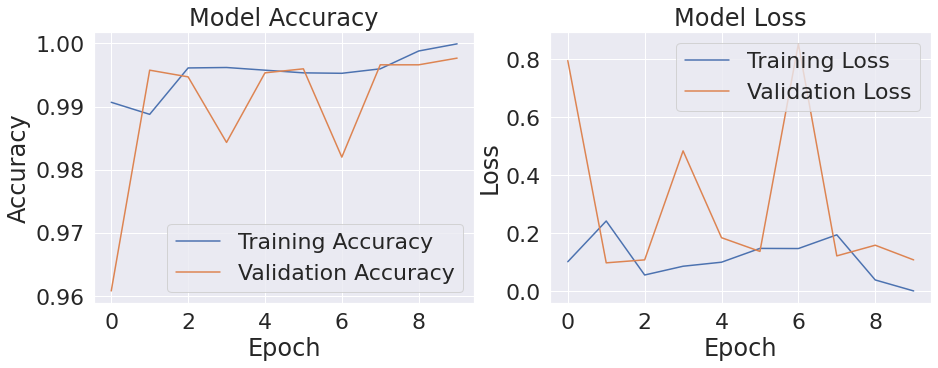

In [49]:
def plot_model_history(model_history):
    ''' 
    Plot the model's training and validation history.
    
    Args:
        model_history (History object): Trained model's history
    '''
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # Summarizing history for accuracy
    axs[0].plot(range(0,len(model_history.history['accuracy'])),model_history.history['accuracy'])
    axs[0].plot(range(0,len(model_history.history['val_accuracy'])),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
    
    # Summarizing history for loss
    axs[1].plot(range(0,len(model_history.history['loss'])),model_history.history['loss'])
    axs[1].plot(range(0, len(model_history.history['val_loss'])),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['Training Loss', 'Validation Loss'], loc='best')
    plt.show()

plot_model_history(history)

# 4. Validation Classification Report and Confusion Matrix

In [50]:
label_predict = np.argmax(model.predict(pix_val), axis=1)  # returns class values between 0 and 3 from highest prediction
label_true = np.argmax(label_val, axis=1) 
classes = ['pylorus (0)', 'z-line (1)','retroflex-stomach (2)']
print("Classification report:\n", classification_report(label_true, label_predict, target_names=classes))

Classification report:
                        precision    recall  f1-score   support

          pylorus (0)       1.00      1.00      1.00      1748
           z-line (1)       1.00      1.00      1.00      1676
retroflex-stomach (2)       1.00      1.00      1.00      1293

             accuracy                           1.00      4717
            macro avg       1.00      1.00      1.00      4717
         weighted avg       1.00      1.00      1.00      4717



### 4.1. Confusion Matrix

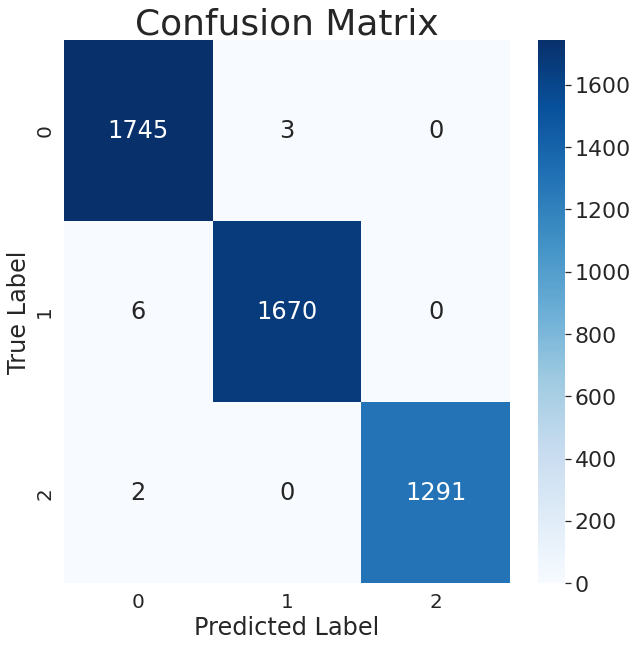

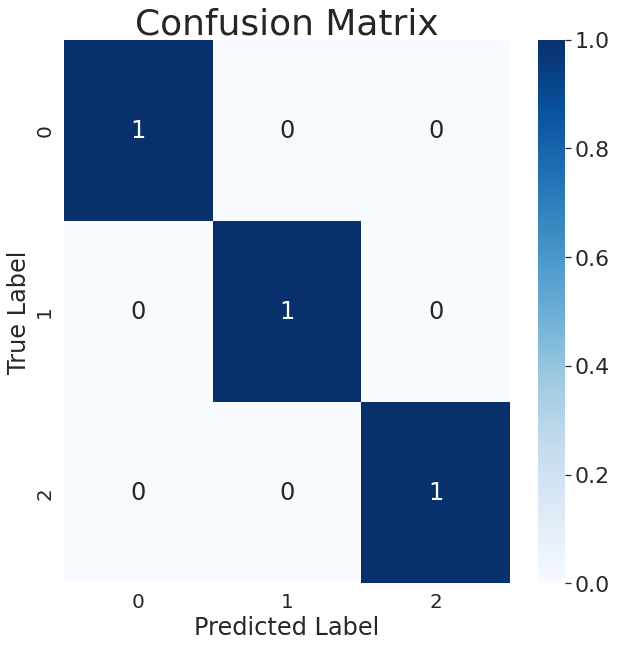

In [51]:
def generate_cm(label_true, label_predict, norm=True):
    ''' Generate the confusion matrix of the model's predictions. The confusion
    Matrix can be normalised or non-normalised.
    
    Source for confusion matrix normalisation:     
    https://stackoverflow.com/questions/59049746/limit-normalised-confusion-matrix-to-2-decimal-points
    
    Args:
    label_true (array): array of true labels
    label_predict (array): array of most probable label predicted by model
    norm (bool): normalise the confusion matrix (True)
    '''
    cm = confusion_matrix(label_true, label_predict)
    if norm == True:  
        cm = np.around(cm.astype('float')/cm.sum(axis=1)[:, np.newaxis], decimals=4)
    plt.figure(figsize=(10,10))
    ax = plt.subplot()
    sbs.heatmap(cm, annot=True, ax=ax, cmap="Blues", fmt="g")
    sbs.set(font_scale=2) 

    # Labels, title and ticks
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    title_font = {'size':'36'}  
    ax.set_title('Confusion Matrix', fontdict=title_font)
    ax.tick_params(axis='both', which='major', labelsize=20) 
    ax.xaxis.set_ticklabels(['0', '1', '2'])
    ax.yaxis.set_ticklabels(['0', '1', '2'])
    plt.show()

generate_cm(label_true, label_predict, False)
generate_cm(label_true, label_predict)

# 5. Testing Classification Report and Confusion Matrix

Classification report:
                        precision    recall  f1-score   support

          pylorus (0)       0.95      0.57      0.72       586
           z-line (1)       0.43      0.83      0.57       147
retroflex-stomach (2)       0.67      0.95      0.78       230

             accuracy                           0.70       963
            macro avg       0.68      0.79      0.69       963
         weighted avg       0.81      0.70      0.71       963



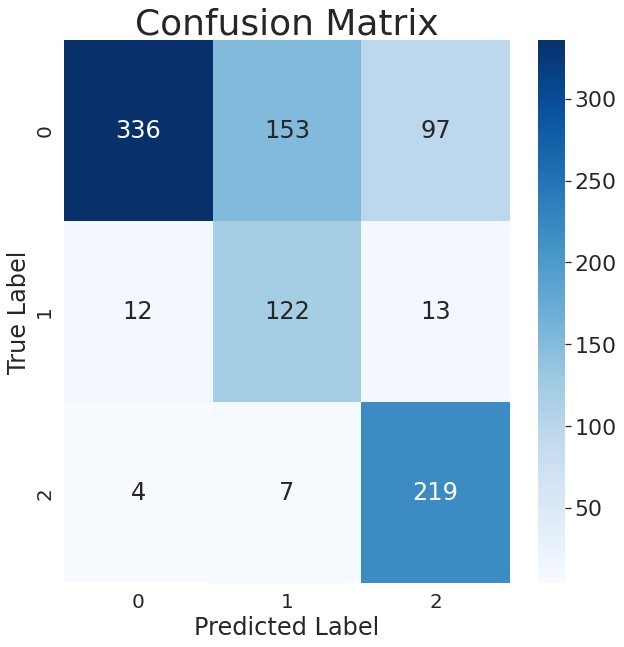

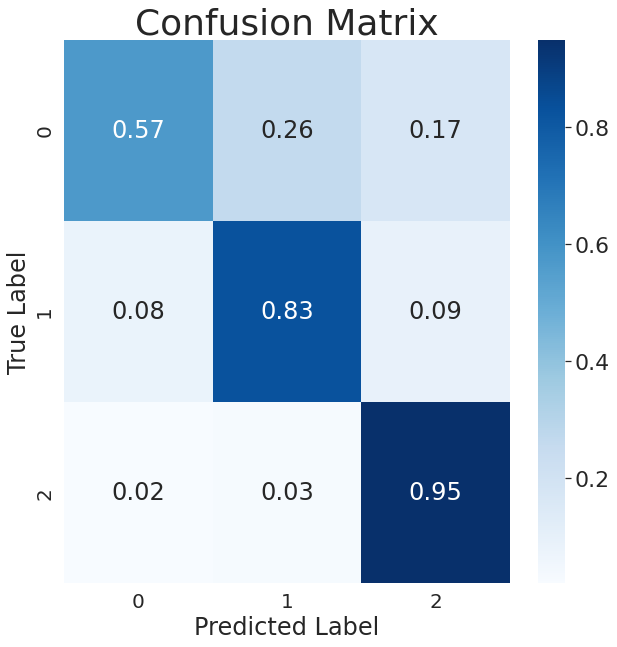

In [52]:
label_predict = np.argmax(model.predict(pix_test), axis=1)  # returns class values between 0 and 3 from highest prediction
label_true = np.argmax(label_test, axis=1) 
classes = ['pylorus (0)', 'z-line (1)','retroflex-stomach (2)']
print("Classification report:\n", classification_report(label_true, label_predict, target_names=classes))
generate_cm(label_true, label_predict, False)
generate_cm(label_true, label_predict)
